In [0]:
import numpy as np
import torch
import pandas as pd
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
import random
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
#sys.path.append('/content/drive/My Drive/Collij/STAT 479 Machine Learning/Deep Learning Project/DEEPakChopra/')
#sys.path.append('/content/drive/My Drive/Colab Notebooks/')
sys.path.append('/content/drive/My Drive/')

Mounted at /content/drive/


In [0]:
########## BEGIN CharRNN ##########
# Character mapping to integers
#with open("/content/drive/My Drive/Collij/STAT 479 Machine Learning/Deep Learning Project/DEEPakChopra/cleanedTweets2.csv", 'r', encoding='utf-8') as f:tweets=f.read()

#with open("/content/drive/My Drive/cleanedTweets2.csv", 'r', encoding='utf-8') as f:tweets=f.read()
with open("/content/drive/My Drive/Colab Notebooks/Deep Learning Project/joinedCleanedDataFinal2.csv", 'r', encoding='utf-8') as f:tweets=f.read()
#with open("/content/drive/My Drive/cleanedTweets2.csv", 'r', encoding='utf-8') as f:tweets=f.read()

#dataframe = pd.read_csv("/content/drive/My Drive/Colab Notebooks/cleaned_book.csv")  
#book_content_list = dataframe['data'].tolist()

tweetChars = []

tweetChars = set(tweets)
char2int = {ch:i for i,ch in enumerate(tweetChars)}
int2char = dict(enumerate(tweetChars))
text_ints = np.array([char2int[ch] for ch in tweets],dtype=np.int32)
#print(tweetChars)
print(text_ints)

[13 15 21 ... 25 28  5]


In [0]:
_lstm_size=250
_num_layers=2
_learning_rate=0.01
_keep_prob=0.6
_grad_clip=5


In [0]:
batches = []

# Function for splitting data
def split_data(sequence, batch_size, num_steps):
    total_length = batch_size * num_steps
    num_batches = int(len(sequence) / total_length)
    if num_batches*total_length + 1 > len(sequence):
        num_batches = num_batches - 1
    # Cut down character stream to length of a batch
    inputs = sequence[0: num_batches * total_length]
    output = sequence[1: num_batches * total_length + 1]
    # Split input & output:
    split_input = np.split(inputs, batch_size)
    split_output = np.split(output, batch_size)
    # Combine the batches
    inputs = np.stack(split_input)
    output = np.stack(split_output)
    return inputs, output


def create_batch_generator(data_x, data_y, num_steps):
    batch_size, total_length = data_x.shape
    num_batches = int(total_length/num_steps)
    for b in range(num_batches):
        yield (data_x[:, b*num_steps:(b+1)*num_steps],
               data_y[:, b*num_steps:(b+1)*num_steps])


def get_top_char(probas, char_size, top_n=5):
    p = np.squeeze(probas)
    p[np.argsort(p)[:-top_n]] = 0.0
    p = p / np.sum(p)
    ch_id = np.random.choice(char_size, 1, p=p)[0]
    return ch_id

# Class for character level recurrent neural network
class CharRNN(object):
    # Constructor (note, the sampling parameter is for determining
    # what mode this object is in (training/sampling), and grad_clip
    # is for preventing exploding gradients
    def __init__(self, num_classes, batch_size=64,
                 num_steps=100, lstm_size = _lstm_size, #lstm_size=128,
                 num_layers = _num_layers, learning_rate = _learning_rate, #num_layers=1, learning_rate=0.001,
                 keep_prob = _keep_prob, grad_clip = _grad_clip, #keep_prob=0.5, grad_clip=5,
                 sampling=False):
        # Set variables to values given by parameters
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.grad_clip = grad_clip
        self.g = tf.Graph()

        with self.g.as_default():
            tf.set_random_seed(123)
            self.build(sampling=sampling)  # builds x and y graphs of data
            self.init_op = tf.global_variables_initializer()
            self.saver = tf.train.Saver()
            

    def build(self, sampling):
        if sampling:
            batch_size, num_steps = 1, 1
        else:
            batch_size = self.batch_size
            num_steps = self.num_steps
        tf_x = tf.placeholder(tf.int32,
                              shape=[batch_size, num_steps],
                              name='tf_x')
        tf_y = tf.placeholder(tf.int32,
                              shape=[batch_size, num_steps],
                              name='tf_y')
        tf_keepprob = tf.placeholder(tf.float32,
                                     name='tf_keepprob')

        # One-hot encoding:
        x_onehot = tf.one_hot(tf_x, depth=self.num_classes)
        y_onehot = tf.one_hot(tf_y, depth=self.num_classes)

        # Build the multi-layer RNN cells
        cells = tf.contrib.rnn.MultiRNNCell(
            [tf.contrib.rnn.DropoutWrapper(
                tf.contrib.rnn.BasicLSTMCell(self.lstm_size),
                output_keep_prob=tf_keepprob)
            for _ in range(self.num_layers)])

        # Define the initial state
        self.initial_state = cells.zero_state(
            batch_size, tf.float32)

        # Run each sequence step through the RNN
        lstm_outputs, self.final_state = tf.nn.dynamic_rnn(
            cells, x_onehot,
            initial_state=self.initial_state)
        print('<< lstm_outputs >>', lstm_outputs)
        seq_output_reshaped = tf.reshape(
            lstm_outputs,
            shape=[-1, self.lstm_size],
            name='seq_output_reshaped')

        logits = tf.layers.dense(
            inputs=seq_output_reshaped,
            units=self.num_classes,
            activation=None,
            name='logits')
        probas = tf.nn.softmax(
            logits,
            name='probabilities')

        y_reshaped = tf.reshape(
            y_onehot,
            shape=[-1, self.num_classes],
            name='y_reshaped')
        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=logits,
                labels=y_reshaped),
            name='cost')

        # Gradient clipping to avoid "exploding gradients"
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(cost, tvars),
            self.grad_clip)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        train_op = optimizer.apply_gradients(
            zip(grads, tvars),
            name='train_op')


    def train(self, train_x, train_y,
        num_epochs, ckpt_dir='./model/'):

        # Create the checkpoint directory
        # if it does not exists
        if not os.path.exists(ckpt_dir):
            os.mkdir(ckpt_dir)

        with tf.Session(graph=self.g) as sess:
            sess.run(self.init_op)
            n_batches = int(train_x.shape[1] / self.num_steps)
            iterations = n_batches * num_epochs
            for epoch in range(num_epochs):

                # Train network
                new_state = sess.run(self.initial_state)
                loss = 0

                # Mini-batch generator
                minibatchgen = create_batch_generator(
                    train_x, train_y, self.num_steps)

                for b, (batch_x, batch_y) in enumerate(minibatchgen, 1):
                    iteration = epoch * n_batches + b
                    feed = {'tf_x:0': batch_x,
                            'tf_y:0': batch_y,
                            'tf_keepprob:0': self.keep_prob,
                            self.initial_state: new_state}
                    batch_cost, _, new_state = sess.run(
                        ['cost:0', 'train_op',
                         self.final_state],
                        feed_dict=feed)
                    if iteration % 10 == 0:
                        print('Epoch %d/%d Iteration %d'
                              '| Training loss: %.4f' % (
                                  epoch + 1, num_epochs,
                                  iteration, batch_cost))
                        batches.append(batch_cost)

                # Save the trained model
                self.saver.save(
                    sess, os.path.join(
                        ckpt_dir, 'language_modeling.ckpt'))


    def sample(self, output_length,
               ckpt_dir, pospriors = ['NN','NN','NN','NN','NN']):
        #print("hi")
        temp = list(tweetChars)
        randFirstLetter = temp[random.randint(0,len(tweetChars) - 1)]
        
        observed_seq = [randFirstLetter]
        starter_seq = [randFirstLetter]
        with tf.Session(graph=self.g) as sess:
            self.saver.restore(
            sess,
            tf.train.latest_checkpoint(ckpt_dir))
            
            # 1: run the model using the starter sequence
            new_state = sess.run(self.initial_state)
            #print(new_state)
            for ch in starter_seq:
                x = np.zeros((1, 1))
                x[0, 0] = char2int[ch.lower()]
                feed = {'tf_x:0': x,
                        'tf_keepprob:0': 1.0,
                        self.initial_state: new_state}
                probas, new_state = sess.run(
                            ['probabilities:0', self.final_state],
                            feed_dict=feed)
            ch_id = get_top_char(probas, len(tweetChars))
            observed_seq.append(int2char[ch_id])

            # 2: run the model using the updated observed_seq
            end_of_last_word = 0
            word_pointer = 0
            i = 2
            while i < output_length and word_pointer < len(pospriors):
                x[0,0] = ch_id
                feed = {'tf_x:0': x,
                'tf_keepprob:0': 1.0,
                        self.initial_state: new_state}
                probas, new_state = sess.run(
                                ['probabilities:0', self.final_state],
                                feed_dict=feed)

                ch_id = get_top_char(probas, len(tweetChars))
                # if we are moving to a new word...
                if ((int2char[ch_id] == " " or int2char[ch_id] == "\n" or i == (output_length - 1))):
                  observed_seq.append(int2char[ch_id])
                  print(observed_seq[end_of_last_word:i])
                  word = ''.join(observed_seq[end_of_last_word:i])
                  print("Word generated: ",word)
                  
                  
                  if (len(nltk.pos_tag(nltk.word_tokenize(word))) != 0):
                    #print(nltk.pos_tag(nltk.word_tokenize(word)))
                    print("Looking for: ",pospriors[word_pointer])
                    print("Word found: ",nltk.pos_tag(nltk.word_tokenize(word))[0][1])
                    pos_of_word = nltk.pos_tag(nltk.word_tokenize(word))[0][1]
                    if (pos_of_word == pospriors[word_pointer]):
                      word_pointer = word_pointer + 1
                      end_of_last_word = i + 1 
                    else: 
                      print("Failed")
                      del observed_seq[end_of_last_word:len(observed_seq)]
                      i = end_of_last_word - 1
                      if (pospriors[word_pointer][1] == ","):
                        observed_seq.append(", ")
                        word_pointer = word_pointer + 1
                  else: 
                    i = i - 1
                else:
                  observed_seq.append(int2char[ch_id])
                i = i + 1

        return ''.join(observed_seq)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
<< lstm_outputs >> Tensor("rnn/transpose_1:0", shape=(64, 100, 250), dtype=float32)
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:

Future major versions of TensorFlow will allo

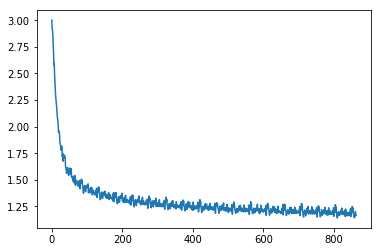

In [0]:
# Begin executing CharRNN
batch_size = 64
num_steps = 100
train_x, train_y = split_data(text_ints,
                                batch_size,
                                num_steps)
rnn = CharRNN(num_classes=len(tweetChars), batch_size=batch_size)
rnn.train(train_x, train_y,
          num_epochs=90,
          ckpt_dir='/content/drive/My Drive/model-100/')

del rnn

np.random.seed(123)
rnn = CharRNN(len(tweetChars), sampling=True)
#print(rnn.sample(ckpt_dir='/content/drive/My Drive/Colab Notebooks/model-100/', output_length=35))
print(rnn.sample(ckpt_dir='/content/drive/My Drive/model-100/', output_length=70,pospriors = ['DT', 'NN', 'VBZ', 'JJ', 'CC', 'RB', 'DT', 'NN', 'IN', 'NN']))

plt.plot(batches)
plt.show()

In [0]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [0]:
import numpy as np
import torch
import pandas as pd
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
import random
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

batch_size = 64
num_steps = 100

#print(rnn.sample(ckpt_dir='/content/drive/My Drive/posmodel-100/', output_length=35, pospriors = ['DT', 'NN', 'VBZ', 'JJ', 'CC', 'RB', 'DT', 'NN', 'IN', 'NN']))
priors_in = pd.read_csv("/content/drive/My Drive/Colab Notebooks/out_pos.csv") 
_pospriors = priors_in['pos_sequence'].tolist()
for i in range(len(_pospriors)):
  print(_pospriors[i])
##########################################################################

batches = []

# Function for splitting data
def split_data(sequence, batch_size, num_steps):
    total_length = batch_size * num_steps
    num_batches = int(len(sequence) / total_length)
    if num_batches*total_length + 1 > len(sequence):
        num_batches = num_batches - 1
    # Cut down character stream to length of a batch
    inputs = sequence[0: num_batches * total_length]
    output = sequence[1: num_batches * total_length + 1]
    # Split input & output:
    split_input = np.split(inputs, batch_size)
    split_output = np.split(output, batch_size)
    # Combine the batches
    inputs = np.stack(split_input)
    output = np.stack(split_output)
    return inputs, output


def create_batch_generator(data_x, data_y, num_steps):
    batch_size, total_length = data_x.shape
    num_batches = int(total_length/num_steps)
    for b in range(num_batches):
        yield (data_x[:, b*num_steps:(b+1)*num_steps],
               data_y[:, b*num_steps:(b+1)*num_steps])


def get_top_char(probas, char_size, top_n=5):
    p = np.squeeze(probas)
    p[np.argsort(p)[:-top_n]] = 0.0
    p = p / np.sum(p)
    ch_id = np.random.choice(char_size, 1, p=p)[0]
    return ch_id

# Class for character level recurrent neural network
class CharRNN(object):
    # Constructor (note, the sampling parameter is for determining
    # what mode this object is in (training/sampling), and grad_clip
    # is for preventing exploding gradients
    def __init__(self, num_classes, batch_size=64,
                 num_steps=100, lstm_size = _lstm_size, #lstm_size=128,
                 num_layers = _num_layers, learning_rate = _learning_rate, #num_layers=1, learning_rate=0.001,
                 keep_prob = _keep_prob, grad_clip = _grad_clip, #keep_prob=0.5, grad_clip=5,
                 sampling=False):
        # Set variables to values given by parameters
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.grad_clip = grad_clip
        self.g = tf.Graph()

        with self.g.as_default():
            tf.set_random_seed(123)
            self.build(sampling=sampling)  # builds x and y graphs of data
            self.init_op = tf.global_variables_initializer()
            self.saver = tf.train.Saver()
            

    def build(self, sampling):
        if sampling:
            batch_size, num_steps = 1, 1
        else:
            batch_size = self.batch_size
            num_steps = self.num_steps
        tf_x = tf.placeholder(tf.int32,
                              shape=[batch_size, num_steps],
                              name='tf_x')
        tf_y = tf.placeholder(tf.int32,
                              shape=[batch_size, num_steps],
                              name='tf_y')
        tf_keepprob = tf.placeholder(tf.float32,
                                     name='tf_keepprob')

        # One-hot encoding:
        x_onehot = tf.one_hot(tf_x, depth=self.num_classes)
        y_onehot = tf.one_hot(tf_y, depth=self.num_classes)

        # Build the multi-layer RNN cells
        cells = tf.contrib.rnn.MultiRNNCell(
            [tf.contrib.rnn.DropoutWrapper(
                tf.contrib.rnn.BasicLSTMCell(self.lstm_size),
                output_keep_prob=tf_keepprob)
            for _ in range(self.num_layers)])

        # Define the initial state
        self.initial_state = cells.zero_state(
            batch_size, tf.float32)

        # Run each sequence step through the RNN
        lstm_outputs, self.final_state = tf.nn.dynamic_rnn(
            cells, x_onehot,
            initial_state=self.initial_state)
        print('<< lstm_outputs >>', lstm_outputs)
        seq_output_reshaped = tf.reshape(
            lstm_outputs,
            shape=[-1, self.lstm_size],
            name='seq_output_reshaped')

        logits = tf.layers.dense(
            inputs=seq_output_reshaped,
            units=self.num_classes,
            activation=None,
            name='logits')
        probas = tf.nn.softmax(
            logits,
            name='probabilities')

        y_reshaped = tf.reshape(
            y_onehot,
            shape=[-1, self.num_classes],
            name='y_reshaped')
        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=logits,
                labels=y_reshaped),
            name='cost')

        # Gradient clipping to avoid "exploding gradients"
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(cost, tvars),
            self.grad_clip)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        train_op = optimizer.apply_gradients(
            zip(grads, tvars),
            name='train_op')


    def train(self, train_x, train_y,
        num_epochs, ckpt_dir='./model/'):

        # Create the checkpoint directory
        # if it does not exists
        if not os.path.exists(ckpt_dir):
            os.mkdir(ckpt_dir)

        with tf.Session(graph=self.g) as sess:
            sess.run(self.init_op)
            n_batches = int(train_x.shape[1] / self.num_steps)
            iterations = n_batches * num_epochs
            for epoch in range(num_epochs):

                # Train network
                new_state = sess.run(self.initial_state)
                loss = 0

                # Mini-batch generator
                minibatchgen = create_batch_generator(
                    train_x, train_y, self.num_steps)

                for b, (batch_x, batch_y) in enumerate(minibatchgen, 1):
                    iteration = epoch * n_batches + b
                    feed = {'tf_x:0': batch_x,
                            'tf_y:0': batch_y,
                            'tf_keepprob:0': self.keep_prob,
                            self.initial_state: new_state}
                    batch_cost, _, new_state = sess.run(
                        ['cost:0', 'train_op',
                         self.final_state],
                        feed_dict=feed)
                    if iteration % 10 == 0:
                        print('Epoch %d/%d Iteration %d'
                              '| Training loss: %.4f' % (
                                  epoch + 1, num_epochs,
                                  iteration, batch_cost))
                        batches.append(batch_cost)

                # Save the trained model
                self.saver.save(
                    sess, os.path.join(
                        ckpt_dir, 'language_modeling.ckpt'))


    def sample(self, output_length,
               ckpt_dir, pospriors = ['NN','NN','NN','NN','NN']):
        #print("hi")
        temp = list(tweetChars)
        randFirstLetter = temp[random.randint(0,len(tweetChars) - 1)]
        
        observed_seq = [randFirstLetter]
        starter_seq = [randFirstLetter]
        with tf.Session(graph=self.g) as sess:
            self.saver.restore(
            sess,
            tf.train.latest_checkpoint(ckpt_dir))
            
            # 1: run the model using the starter sequence
            new_state = sess.run(self.initial_state)
            #print(new_state)
            for ch in starter_seq:
                x = np.zeros((1, 1))
                x[0, 0] = char2int[ch.lower()]
                feed = {'tf_x:0': x,
                        'tf_keepprob:0': 1.0,
                        self.initial_state: new_state}
                probas, new_state = sess.run(
                            ['probabilities:0', self.final_state],
                            feed_dict=feed)
            ch_id = get_top_char(probas, len(tweetChars))
            observed_seq.append(int2char[ch_id])

            # 2: run the model using the updated observed_seq
            end_of_last_word = 0
            word_pointer = 0
            i = 2
            while i < output_length and word_pointer < len(pospriors):
                x[0,0] = ch_id
                feed = {'tf_x:0': x,
                'tf_keepprob:0': 1.0,
                        self.initial_state: new_state}
                probas, new_state = sess.run(
                                ['probabilities:0', self.final_state],
                                feed_dict=feed)

                ch_id = get_top_char(probas, len(tweetChars))
                # if we are moving to a new word...
                if ((int2char[ch_id] == " " or int2char[ch_id] == "\n" or i == (output_length - 1))):
                  observed_seq.append(int2char[ch_id])
                  print(observed_seq[end_of_last_word:i])
                  word = ''.join(observed_seq[end_of_last_word:i])
                  print("Word generated: ",word)
                  
                  
                  if (len(nltk.pos_tag(nltk.word_tokenize(word))) != 0):
                    #print(nltk.pos_tag(nltk.word_tokenize(word)))
                    print("Looking for: ",pospriors[word_pointer])
                    print("Word found: ",nltk.pos_tag(nltk.word_tokenize(word))[0][1])
                    pos_of_word = nltk.pos_tag(nltk.word_tokenize(word))[0][1]
                    if (pos_of_word == pospriors[word_pointer]):
                      word_pointer = word_pointer + 1
                      end_of_last_word = i + 1 
                    else: 
                      print("Failed")
                      del observed_seq[end_of_last_word:len(observed_seq)]
                      i = end_of_last_word - 1
                      if (pospriors[word_pointer][1] == ","):
                        observed_seq.append(", ")
                        word_pointer = word_pointer + 1
                  else: 
                    i = i - 1
                else:
                  observed_seq.append(int2char[ch_id])
                i = i + 1

        return ''.join(observed_seq)
      
      
np.random.seed(123)
rnn = CharRNN(len(tweetChars), sampling=True)
print(rnn.sample(ckpt_dir='/content/drive/My Drive/model-100/', output_length=70,pospriors = ['DT', 'NN', 'VBZ', 'JJ', 'CC', 'RB', 'DT', 'NN', 'IN', 'NN']))




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
DT
NNS
VBP
DT
NN
NN
IN
DT
NN
,
CC
DT
NN
VBZ
VBN
IN
NNS
<< lstm_outputs >> Tensor("rnn/transpose_1:0", shape=(1, 1, 250), dtype=float32)
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/model-100/language_modeling.ckpt
['a', ' ', 't', 'h', 'e']
Word generated:  a the
Looking for:  DT
Word found:  DT
['p', 'o', 'i', 'n', 't']
Word generated:  point
Looking for:  NN
Word found:  NN
['o', 'f']
Word generated:  of
Looking for:  VBZ
Word found:  IN
Failed
['t', 'e', 'r', 'r', 'o', 'r', 'i', 's', 'm']
Word generated:  terrorism
Looking for:  VBZ
Word found:  NN
Failed
[]
Word generated:  
[' ', 't', 'h']
Word generated:   th
Looking for:  VBZ
Word found:  NN
Failed
['s', 'a', 'm', '